In [1]:
import os,sys
smodelsPath = os.path.expanduser('~/smodels')
sys.path.append(smodelsPath)
from smodels.experiment.databaseObj import Database
from smodels.tools.physicsUnits import GeV
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
from scipy.special import kn,zetac
sns.set() #Set style
sns.set_style('ticks',{'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
sns.set_palette(sns.color_palette("Paired"))
cm = plt.cm.get_cmap('RdYlBu')

In [2]:
db = Database('/home/lessa/smodels-database')

In [3]:
exp = db.getExpResults(analysisIDs = 'ATLAS-SUSY-2016-32', dataTypes = 'efficiencyMap')[0]
print(exp)

ATLAS-SUSY-2016-32: SR1FULL_175,SR1FULL_375,SR1FULL_600,SR1FULL_825,SR2FULL_150,SR2FULL_350,SR2FULL_575,SR2FULL_800(8):THSCPM1b,THSCPM2b,THSCPM3,THSCPM4,THSCPM5,THSCPM6,THSCPM7,THSCPM8,THSCPM9(9)


### Use the trimmed database to interpolate over all original map points

In [4]:
datasetNames = ['SR2FULL_150','SR2FULL_350','SR2FULL_575','SR2FULL_800', 
                'SR1FULL_175', 'SR1FULL_375', 'SR1FULL_600', 'SR1FULL_825']
txNames = ['THSCPM1b','THSCPM3','THSCPM4','THSCPM5', 'THSCPM6','THSCPM7','THSCPM8','THSCPM9']

resultsDict = {}
for tx in txNames:

    #Skip maps without width information
    if tx in ['THSCPM5', 'THSCPM6','THSCPM7']:
        continue
        
    resultsDict[tx] = []        
    
    for ds in datasetNames:
        print(tx,ds)
        dataset = [dds for dds in exp.datasets if dds.dataInfo.dataId == ds][0]
        txname = [t for t in dataset.txnameList if t.txName == tx]
        if not txname:
            continue
        txname = txname[0]
        results = []

        data = np.genfromtxt('./orig/%s_eff_mutrig_%s.dat' %(tx,ds),names=True)
        for pt in data:
            massvals = [pt[mlabel] for mlabel in ['mprod','mint','mhscp'] if mlabel in data.dtype.names]
            width = 0.0
            if 'width' in data.dtype.names:
                width = pt['width']

            mass = [m*GeV for m in massvals]
            mass[-1] = tuple([mass[-1],width*GeV])
            mass = [mass]*2
            eff = pt[ds]
            effInterp = txname.txnameData.getValueFor(mass)
            results.append([eff,effInterp])
        
        resultsDict[tx] += results
        

THSCPM1b SR2FULL_150
THSCPM1b SR2FULL_350
THSCPM1b SR2FULL_575
THSCPM1b SR2FULL_800
THSCPM1b SR1FULL_175
THSCPM1b SR1FULL_375
THSCPM1b SR1FULL_600
THSCPM1b SR1FULL_825
THSCPM3 SR2FULL_150
THSCPM3 SR2FULL_350
THSCPM3 SR2FULL_575
THSCPM3 SR2FULL_800
THSCPM3 SR1FULL_175
THSCPM3 SR1FULL_375
THSCPM3 SR1FULL_600
THSCPM3 SR1FULL_825
THSCPM4 SR2FULL_150
THSCPM4 SR2FULL_350
THSCPM4 SR2FULL_575
THSCPM4 SR2FULL_800
THSCPM4 SR1FULL_175
THSCPM4 SR1FULL_375
THSCPM4 SR1FULL_600
THSCPM4 SR1FULL_825
THSCPM8 SR2FULL_150
THSCPM8 SR2FULL_350
THSCPM8 SR2FULL_575
THSCPM8 SR2FULL_800
THSCPM8 SR1FULL_175
THSCPM8 SR1FULL_375
THSCPM8 SR1FULL_600
THSCPM8 SR1FULL_825
THSCPM9 SR2FULL_150
THSCPM9 SR2FULL_350
THSCPM9 SR2FULL_575
THSCPM9 SR2FULL_800
THSCPM9 SR1FULL_175
THSCPM9 SR1FULL_375
THSCPM9 SR1FULL_600
THSCPM9 SR1FULL_825


In [5]:
for tx in resultsDict:
    resultsDict[tx] = np.array(resultsDict[tx])
    print(tx,'# points outside the grid:',len(np.where(resultsDict[tx][:,1] == None)[0]))

THSCPM1b # points outside the grid: 0
THSCPM3 # points outside the grid: 0
THSCPM4 # points outside the grid: 0
THSCPM8 # points outside the grid: 0
THSCPM9 # points outside the grid: 0


In [6]:
relDiffDict = {}
for tx,results in resultsDict.items():
    relDiffDict[tx] = np.where(results[:,0] > 1e-6, 
                                np.abs(results[:,1]-results[:,0])/results[:,0],results[:,1])

<ipython-input-6-1e7ff10e186b>:4: RuntimeWarning: divide by zero encountered in true_divide
  np.abs(results[:,1]-results[:,0])/results[:,0],results[:,1])
<ipython-input-6-1e7ff10e186b>:4: RuntimeWarning: overflow encountered in true_divide
  np.abs(results[:,1]-results[:,0])/results[:,0],results[:,1])
<ipython-input-6-1e7ff10e186b>:4: RuntimeWarning: invalid value encountered in true_divide
  np.abs(results[:,1]-results[:,0])/results[:,0],results[:,1])


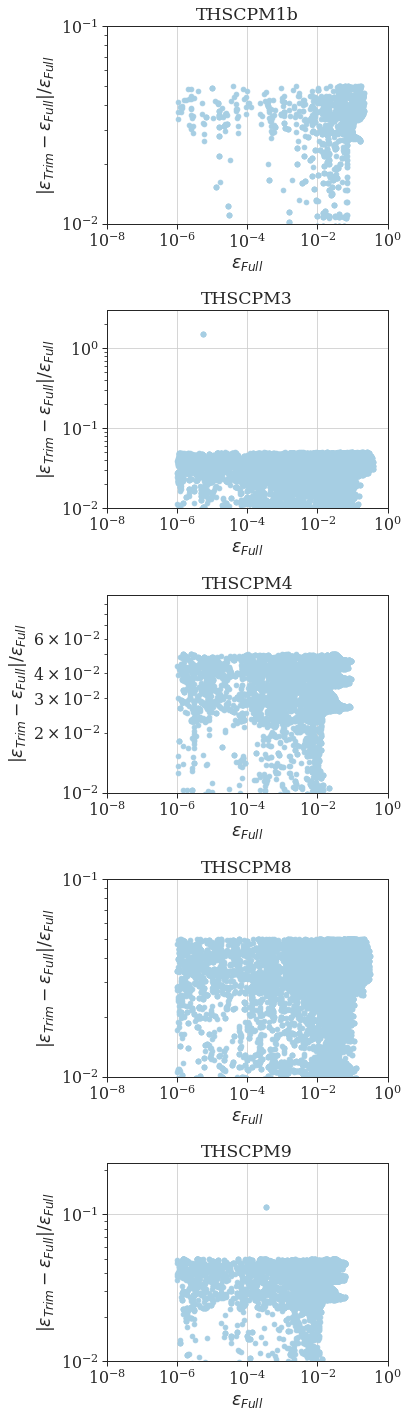

In [7]:
fig,ax = plt.subplots(nrows = len(relDiffDict),figsize = (6,20),sharex=False)

for i,tx in enumerate(relDiffDict):

    ax[i].scatter(resultsDict[tx][:,0],relDiffDict[tx])
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')
    ax[i].set_ylim(1e-2,2*relDiffDict[tx].max())
    ax[i].set_xlim(1e-8,1)
#     ax[i].set_xticks(np.logspace(-3,3,16))
#     ax[i].text(1e-3,3e4,'%s : max diff = %1.1f %%' %(tx,100*(relDiffDict[tx].max())))
    ax[i].set_title(tx)
    ax[i].set_xlabel(r'$\epsilon_{Full}$')
    ax[i].set_ylabel(r'$|\epsilon_{Trim}-\epsilon_{Full}|/\epsilon_{Full}$')
    ax[i].grid()
    
plt.tight_layout()
plt.savefig('trimmedDiff.png')
plt.show()



In [8]:
for tx in txNames:
    
    #Skip maps without width information
    if tx in ['THSCPM5', 'THSCPM6','THSCPM7']:
        continue
    
    for ds in datasetNames:
        print(tx,ds)
        dataset = [dds for dds in exp.datasets if dds.dataInfo.dataId == ds][0]
        txname = [t for t in dataset.txnameList if t.txName == tx]
        if not txname:
            continue
        txname = txname[0]
        vals = txname.txnameData.y_values
        print(len(np.where(vals > 1e-6)[0]))

THSCPM1b SR2FULL_150
422
THSCPM1b SR2FULL_350
357
THSCPM1b SR2FULL_575
285
THSCPM1b SR2FULL_800
239
THSCPM1b SR1FULL_175
385
THSCPM1b SR1FULL_375
331
THSCPM1b SR1FULL_600
263
THSCPM1b SR1FULL_825
222
THSCPM3 SR2FULL_150
4634
THSCPM3 SR2FULL_350
3968
THSCPM3 SR2FULL_575
3205
THSCPM3 SR2FULL_800
2513
THSCPM3 SR1FULL_175
4264
THSCPM3 SR1FULL_375
3762
THSCPM3 SR1FULL_600
3122
THSCPM3 SR1FULL_825
2515
THSCPM4 SR2FULL_150
THSCPM4 SR2FULL_350
THSCPM4 SR2FULL_575
THSCPM4 SR2FULL_800
THSCPM4 SR1FULL_175
4182
THSCPM4 SR1FULL_375
3717
THSCPM4 SR1FULL_600
3084
THSCPM4 SR1FULL_825
2498
THSCPM8 SR2FULL_150
4635
THSCPM8 SR2FULL_350
3969
THSCPM8 SR2FULL_575
3215
THSCPM8 SR2FULL_800
2516
THSCPM8 SR1FULL_175
4375
THSCPM8 SR1FULL_375
3841
THSCPM8 SR1FULL_600
3166
THSCPM8 SR1FULL_825
2537
THSCPM9 SR2FULL_150
THSCPM9 SR2FULL_350
THSCPM9 SR2FULL_575
THSCPM9 SR2FULL_800
THSCPM9 SR1FULL_175
4229
THSCPM9 SR1FULL_375
3742
THSCPM9 SR1FULL_600
3090
THSCPM9 SR1FULL_825
2498
